# ResNets

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

## CNN for MNIST 

In [0]:
bs = 

In [0]:
path = untar_data(URLs.MNIST)

In [39]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
i1 = ImageList.from_folder(path, convert_mode='L')

In [41]:
i1.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/8/48092.png')

In [0]:
defaults.cmap='binary'

In [43]:
i1

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

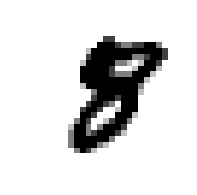

In [44]:
i1[0].show()

In [0]:
sd = i1.split_by_folder(train='training', valid='testing')

Testing here indicates the validation set (i.e. has the ground truth/labels)

In [46]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

Folders for each class

In [47]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/0')]

In [0]:
ll = sd.label_from_folder()

In [49]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x, y = ll.train[0]

8 torch.Size([1, 28, 28])


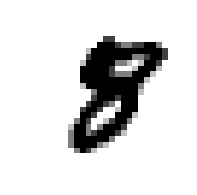

In [52]:
x.show()
print(y, x.shape)

Adding some random padding

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

`.normalize()` grabs data at random and uses its features to normalize 

In [0]:
data = ll.databunch(bs=bs).normalize() # Not using imagenet stats

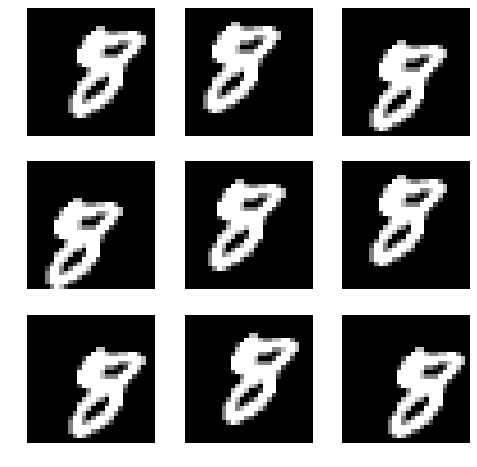

In [60]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

> Note : The random padding results in the images of 8 slightly shifting.

In [61]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

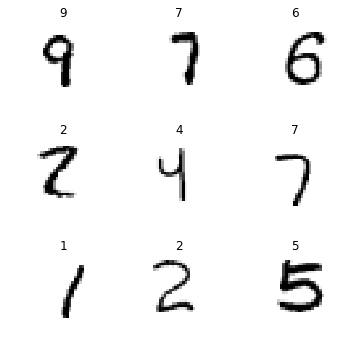

In [62]:
data.show_batch(rows=3, figsize=(5,5))

## Basic ConvNet with batchnorm

In [0]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

A stride of 2 will lead to a half sized input i.e. 14x14

### CNN Architecture

In [0]:
model = nn.Sequential(
    conv(1, 8), # 1 channel in, 8 channels out, returns 8 x 14 x 14 feature map
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 8 channel in, 16 channels out, returns 16 x 7 x 7 feature map
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 16 channel in, 32 channels out, returns 32 x 4 x 4 feature map
    # 4 because math.ceil(7/2) = 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 32 channel in, 16 channels out, returns 16 x 2 x 2 feature map
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 16 channels in, 10 channels out, returns 10 x 1 x 1 feature map 
    # i.e. its a tensor of rank 3 [10 x 1 x 1] shape
    nn.BatchNorm2d(10),
    Flatten() # remove (1,1) grid
)

- Flatten just removes anu units axes.
- In this case it will convert rank-3 tensor of 10 x 1 x 1 to rank-1 tensor or vector of length 10

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [72]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

### Sanity check

In [0]:
xb = xb.cuda()

In [74]:
model(xb).shape

torch.Size([128, 10])

In [75]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.00E-01
Min loss divided by 10: 1.02E+00


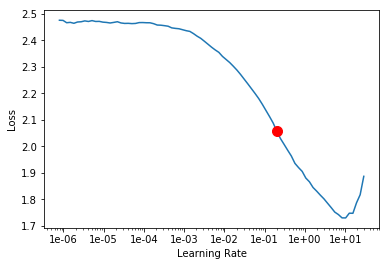

In [78]:
learn.recorder.plot(suggestion=True)

Selecting initial lr as **1e-01**

In [79]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.227289,0.174879,0.944500,00:28
1,0.134290,0.083074,0.975100,00:28
2,0.071327,0.045820,0.985600,00:27


> Accuracy : 98.6%

## Refactor

`conv_layer` in fastai has the conv2d batchnorm and ReLU combination in-built

In [0]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [89]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
___________________________________________________

Exactly the same architecture as before.

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-01
Min loss divided by 10: 1.58E-01


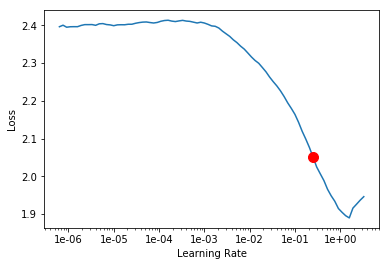

In [91]:
learn.recorder.plot(suggestion=True)

In [92]:
learn.fit_one_cycle(10, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.227982,0.141141,0.955600,00:27
1,0.187402,0.291858,0.905400,00:27
2,0.160548,0.165445,0.952800,00:27
3,0.122353,0.138911,0.958200,00:27
4,0.123963,0.145013,0.955800,00:27
5,0.100189,0.077624,0.976400,00:27
6,0.086437,0.050799,0.982900,00:27
7,0.065064,0.041983,0.986000,00:27
8,0.045680,0.032509,0.989300,00:27
9,0.045259,0.030866,0.989600,00:27


## ResNet

In order to build a deeper CNN network, we can
- Simply add a stride 1 conv after stride 2 conv, since a stride 1 conv does not change the size of the feature map (whereas in the case of stride 2, it halves the size)

From Microsoft Research,
- **Deep Residual Learning for Image Recognition** : https://arxiv.org/abs/1512.03385
- Looking at the training error for CIFAR10, 56 layer vs 20 layer networks
- 56 layer one has a lot more params 
- The expectation with the 56 layer network was that it would seriously overfit
- But that did not happen. It performed had worse training error
- Every 2 convolutions, add together the input to the 2 convs
- So instead of,
$$output=C2(C1(x))$$
- They went 
$$output=x+C2(C1(x))$$
- They added the identity connections or skip connections
- ResBlocks! Adding ResBlocks to standard CNNs almost always leads to better performance
- Visualizing loss landscapes : https://arxiv.org/abs/1712.09913

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super.__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
    
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

In [96]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



With ResBlock

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    res_block(8),
    conv2(8, 16),  # 7
    res_block(16),
    conv2(16, 32), # 4
    res_block(32),
    conv2(32, 16), # 2
    res_block(16),
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

Refactoring again

In [0]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),   # 14
    conv_and_res(8, 16),  # 7
    conv_and_res(16, 32), # 4
    conv_and_res(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

> Note : Always keep refactoring to keep errors at bay!

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [102]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

In [103]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-01
Min loss divided by 10: 1.58E-01


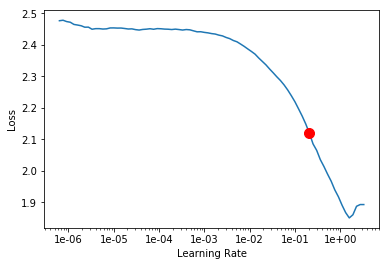

In [105]:
learn.recorder.plot(suggestion=True)

In [106]:
learn.fit_one_cycle(12, max_lr=5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.257022,0.184213,0.951200,00:30
1,0.132965,0.102803,0.970500,00:29
2,0.108540,0.092987,0.971900,00:29
3,0.095469,0.095387,0.969600,00:29
4,0.066686,0.053341,0.983000,00:29
5,0.064911,0.113114,0.962700,00:29
6,0.056524,0.035624,0.988000,00:29
7,0.040790,0.025054,0.991200,00:29
8,0.036685,0.023885,0.992100,00:30
9,0.025595,0.022459,0.992800,00:29


## DenseNet

- If we use concatenate instead of addition, we get a dense block.
- DenseNet can be memory intensive
- Very few parameters
- Tend to work very well with small datasets
- Contains all the original pixels